In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [3]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.models.cvae_inference import CVAE
from cvaei.helper import DataNormalizer
from cvaei.visualize import scatter_plot_ma2
from cvaei.examples.MA2 import MovingAverage2
from cvaei.examples.two_moons import TwoMoons

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


In [4]:
two_moons = TwoMoons()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer = two_moons.prepare_data(100000)
observed_data = two_moons.observed_data()
two_moons.check_normalizer()

Normalization and denormalization process is consistent for both parameters and observed data.


# Initialise the Model

In [5]:
# ma2 = MovingAverage2()
# train_theta_norm, train_data_norm, theta_normalizer, data_normalizer = ma2.prepare_data(1000)
# observed_data = ma2.observed_data()
# print(ma2.check_normalizer())

test = torch.tensor([0.4409, 0.5635], dtype = torch.float32)
two_moons.simulator(test)

tensor([-0.4264,  0.1740])

In [6]:
two_moons.simulator(test)

tensor([-0.4264,  0.1740])

In [7]:
two_moons.simulator(test)

tensor([-0.4264,  0.1740])

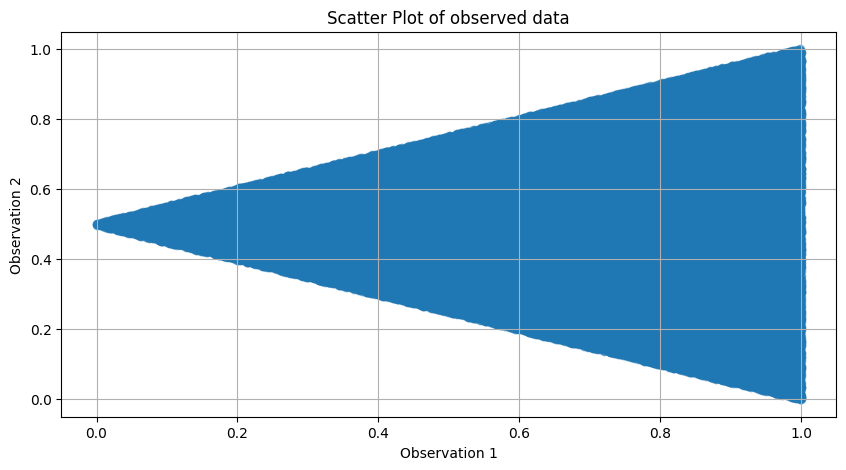

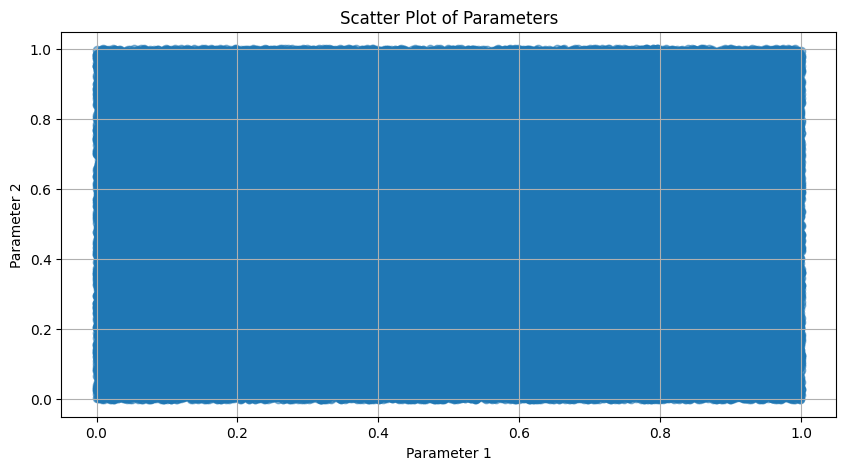

In [8]:
two_moons.plot_observation(train_data_norm)
two_moons.plot_prior(train_theta_norm)

# Define the CVAE Network

In [9]:
input_dim = 2
latent_dim = 20
conditional_dim = 2
encoder_hidden_dims = [100]
decoder_hidden_dims = [2048,2048,2048]
activation_fn = nn.LeakyReLU(0.1)

network = CVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn)


optimizer = optim.AdamW(network.parameters(), lr=1e-3)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)

print(network)

CVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
    )
    (fc_mean): Linear(in_features=100, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=100, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=22, out_features=2048, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=2048, out_features=2048, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
      (4): Linear(in_features=2048, out_features=2048, bias=True)
      (5): LeakyReLU(negative_slope=0.1)
    )
    (final_layer): Linear(in_features=2048, out_features=2, bias=True)
  )
)


In [10]:
network.train_model(train_loader=train_loader, optimizer=optimizer, epochs=50, 
                    device=device, theta_normalizer=theta_normalizer,
                      data_normalizer=data_normalizer, forward_model= two_moons.simulator)

Using CPU
Epoch 1/50, Beta: 0.0, Total Loss: 147543.9729, Recon Loss: 57943.9022, Misfit Loss: 89600.0705, KL Div: 40482.2148
Epoch 2/50, Beta: 0.1, Total Loss: 20040.5044, Recon Loss: 7832.3582, Misfit Loss: 10312.4811, KL Div: 18956.6517
Epoch 3/50, Beta: 0.2, Total Loss: 15973.6010, Recon Loss: 6223.1647, Misfit Loss: 7998.8698, KL Div: 8757.8327
Epoch 4/50, Beta: 0.3, Total Loss: 13364.5867, Recon Loss: 5137.9110, Misfit Loss: 6365.0198, KL Div: 6205.5194
Epoch 5/50, Beta: 0.4, Total Loss: 12393.1260, Recon Loss: 4682.9482, Misfit Loss: 5962.8099, KL Div: 4368.4197
Epoch 6/50, Beta: 0.5, Total Loss: 11357.9770, Recon Loss: 4137.2790, Misfit Loss: 5554.2020, KL Div: 3332.9922
Epoch 7/50, Beta: 0.6, Total Loss: 12730.5934, Recon Loss: 4740.6874, Misfit Loss: 6363.9077, KL Div: 2709.9973
Epoch 8/50, Beta: 0.7, Total Loss: 10308.2018, Recon Loss: 3542.1027, Misfit Loss: 5149.6673, KL Div: 2309.1883
Epoch 9/50, Beta: 0.8, Total Loss: 10728.1325, Recon Loss: 3788.2349, Misfit Loss: 5333.

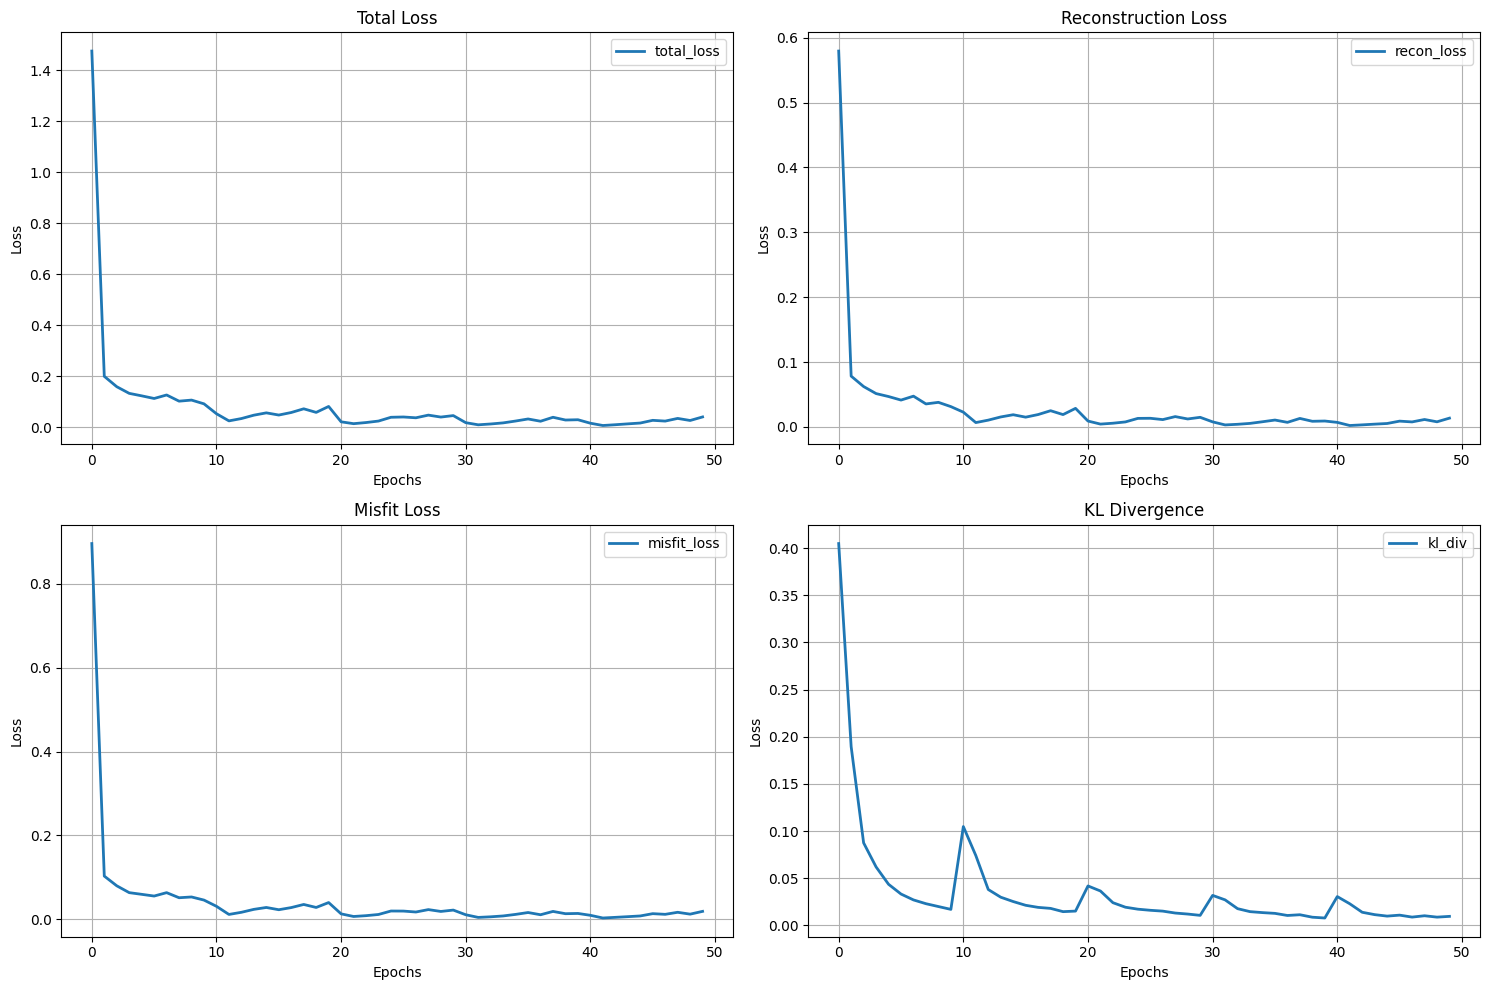

In [11]:
network.plot_loss()

# Inference

In [12]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)


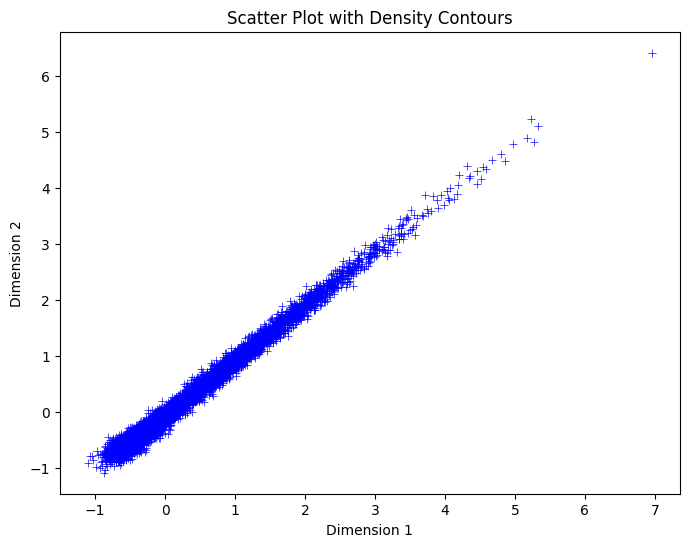

In [13]:
two_moons.plot_posterior(post)

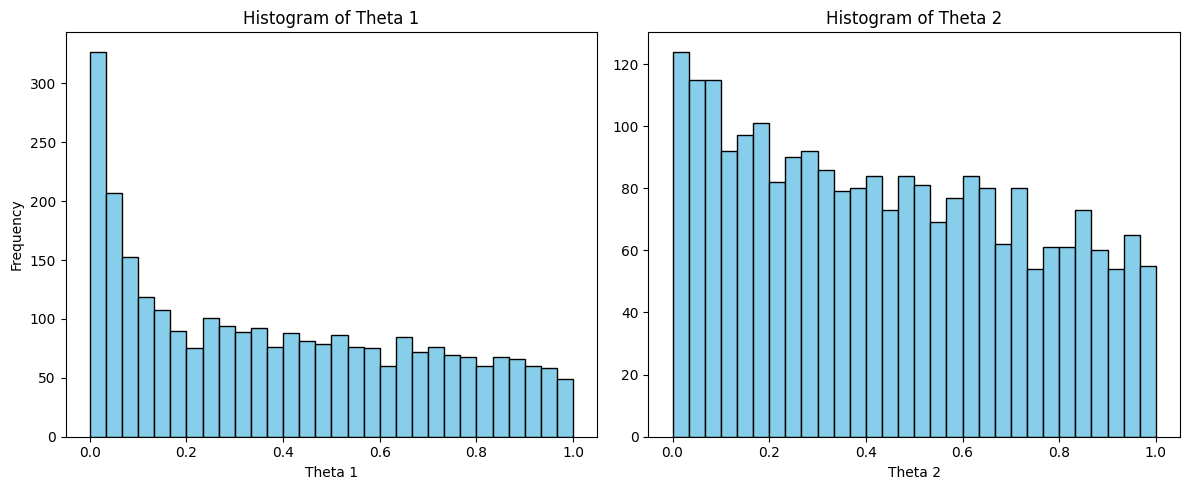

In [14]:
two_moons.posterior_hist(post)

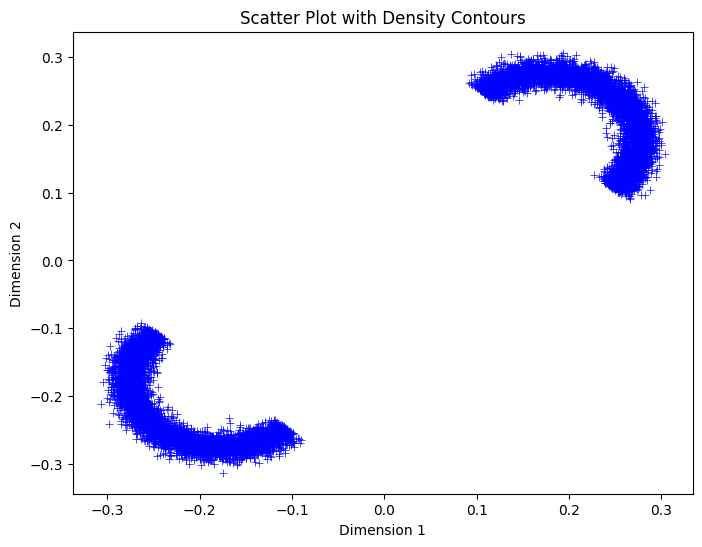

In [15]:
two_moons.analytic_posterior()